# Position - Linearization


## Overview


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)

This pipeline takes 2D position data from the `PositionOutput` table and
"linearizes" it to 1D position. If you haven't already done so, please generate
input data with either the [Trodes](./20_Position_Trodes.ipynb) or DLC notebooks
([1](./21_Position_DLC_1.ipynb), [2](./22_Position_DLC_2.ipynb),
[3](./23_Position_DLC_3.ipynb)).


## Imports


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pynwb
import numpy as np
import datajoint as dj
import matplotlib.pyplot as plt

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

import spyglass.common as sgc
import spyglass.position.v1 as sgp
import spyglass.linearization.v1 as sgpl

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

[2024-01-24 09:19:28,736][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-01-24 09:19:28,767][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
[09:19:30][WARNING] Spyglass: Please update position_tools to >= 0.1.0


## Retrieve 2D position


To retrieve 2D position data, we'll specify an nwb file, a position time
interval, and the set of parameters used to compute the position info.


In [3]:
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

nwb_file_name = "minirec20230622.nwb"  # detailed data: chimi20200216_new.nwb
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
nwb_copy_file_name

'chimi20200216_new_.nwb'

We will fetch the pandas dataframe from the `PositionOutput` table.


In [4]:
from spyglass.position import PositionOutput
import pandas as pd

pos_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": "pos 0 valid times",  # For chimi, "pos 1 valid times"
    "trodes_pos_params_name": "single_led_upsampled",  # For chimi, "default"
}

# Note: You'll have to change the part table to the one where your data came from
merge_id = (PositionOutput.TrodesPosV1() & pos_key).fetch1("merge_id")
position_info = (PositionOutput & {"merge_id": merge_id}).fetch1_dataframe()
position_info

,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,,
1.581887e+09,0,91.051650,211.127050,2.999696,1.387074,2.848838,3.168573
1.581887e+09,1,90.844337,211.417287,3.078386,3.123201,3.411111,4.624939
1.581887e+09,2,90.637025,211.707525,-3.114572,5.431643,4.089597,6.799085
1.581887e+09,3,90.802875,211.596958,-3.033109,8.097753,4.979262,9.506138
1.581887e+09,4,91.288579,211.482443,-3.062550,10.840482,6.071373,12.424880
...,...,...,...,...,...,...,...
1.581888e+09,39335,182.158583,201.452467,-0.986926,0.348276,0.218575,0.411182
1.581888e+09,39336,182.158583,201.397183,-0.978610,0.279135,-0.058413,0.285182
1.581888e+09,39337,182.213867,201.341900,-0.957589,0.193798,-0.283200,0.343162


Before linearizing, plotting the head position will help us understand the data.


Text(0.5, 1.0, 'Head Position')

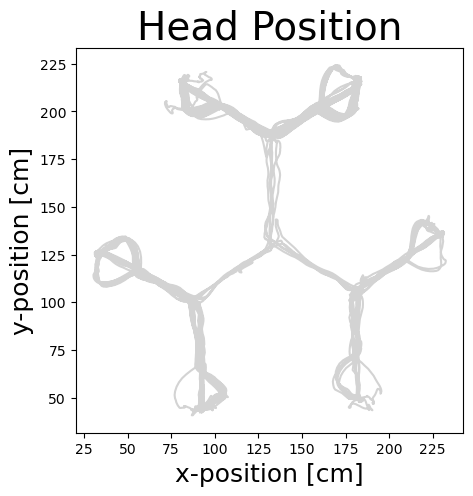

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(
    position_info.position_x,
    position_info.position_y,
    color="lightgrey",
)
ax.set_xlabel("x-position [cm]", fontsize=18)
ax.set_ylabel("y-position [cm]", fontsize=18)
ax.set_title("Head Position", fontsize=28)

## Specifying the track


To linearize, we need a graph of nodes and edges to represent track geometry in
the `TrackGraph` table with four variables:

- `node_positions` (cm): the 2D positions of the graph
- `edges`: how the nodes are connected, as pairs of node indices, labeled by
  their respective index in `node_positions`.
- `linear_edge_order`: layout of edges in linear space in _order_, as tuples.
- `linear_edge_spacing`: spacing between each edge, as either a single number
  for all gaps or an array with a number for each gap. Gaps may be important for
  edges not connected in 2D space.

For example, (79.910, 216.720) is the 2D position of node 0 and (183.784,
45.375) is the 2D position of node 8. Edge (0, 8) means there is an edge between
node 0 and node 8. Nodes order controls order in 1D space. Edge (0, 1) connects
from node 0 to 1. Edge (1, 0) would connect from node 1 to 0, reversing the
linear positions for that edge.

For more examples, see
[this notebook](https://github.com/LorenFrankLab/track_linearization/blob/master/notebooks/).


In [6]:
node_positions = np.array(
    [
        (79.910, 216.720),  # top left well 0
        (132.031, 187.806),  # top middle intersection 1
        (183.718, 217.713),  # top right well 2
        (132.544, 132.158),  # middle intersection 3
        (87.202, 101.397),  # bottom left intersection 4
        (31.340, 126.110),  # middle left well 5
        (180.337, 104.799),  # middle right intersection 6
        (92.693, 42.345),  # bottom left well 7
        (183.784, 45.375),  # bottom right well 8
        (231.338, 136.281),  # middle right well 9
    ]
)

edges = np.array(
    [
        (0, 1),
        (1, 2),
        (1, 3),
        (3, 4),
        (4, 5),
        (3, 6),
        (6, 9),
        (4, 7),
        (6, 8),
    ]
)

linear_edge_order = [
    (3, 6),
    (6, 8),
    (6, 9),
    (3, 1),
    (1, 2),
    (1, 0),
    (3, 4),
    (4, 5),
    (4, 7),
]
linear_edge_spacing = 15

With these variables, we then add a `track_graph_name` and the corresponding
`environment`.


In [7]:
sgpl.TrackGraph.insert1(
    {
        "track_graph_name": "6 arm",
        "environment": "6 arm",
        "node_positions": node_positions,
        "edges": edges,
        "linear_edge_order": linear_edge_order,
        "linear_edge_spacing": linear_edge_spacing,
    },
    skip_duplicates=True,
)

graph = sgpl.TrackGraph & {"track_graph_name": "6 arm"}
graph

track_graph_name,environment Type of Environment,"node_positions 2D position of track_graph nodes, shape (n_nodes, 2)","edges shape (n_edges, 2)","linear_edge_order order of track graph edges in the linear space, shape (n_edges, 2)","linear_edge_spacing amount of space between edges in the linear space, shape (n_edges,)"
6 arm,6 arm,=BLOB=,=BLOB=,=BLOB=,=BLOB=


`TrackGraph` has several methods for visualizing in 2D and 1D space.
`plot_track_graph` plots in 2D to make sure our layout makes sense.


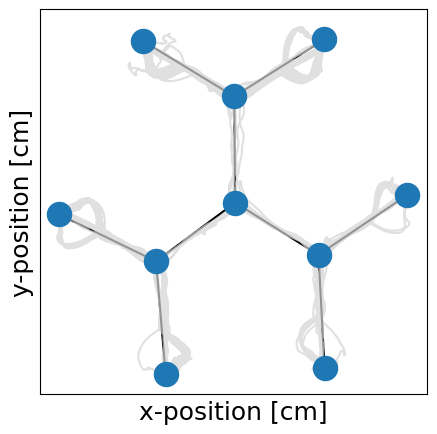

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(
    position_info.position_x,
    position_info.position_y,
    color="lightgrey",
    alpha=0.7,
    zorder=0,
)
ax.set_xlabel("x-position [cm]", fontsize=18)
ax.set_ylabel("y-position [cm]", fontsize=18)
graph.plot_track_graph(ax=ax)

`plot_track_graph_as_1D` shows what this looks like in 1D.


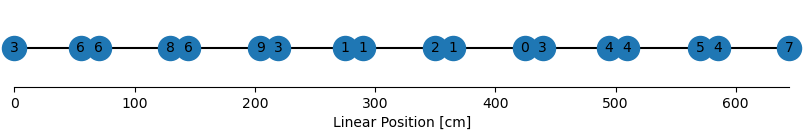

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 1))
graph.plot_track_graph_as_1D(ax=ax)

## Parameters


By default, linearization assigns each 2D position to its nearest point on the
track graph. This is then translated into 1D space.

If `use_hmm` is set to `true`, a Hidden Markov model is used to assign points.
The HMM takes into account the prior position and edge, and can keep the
position from suddenly jumping to another. Position jumping like this may occur
at intersections or the head position swings closer to a non-target reward well
while on another edge.


In [10]:
sgpl.LinearizationParameters.insert1(
    {"linearization_param_name": "default"}, skip_duplicates=True
)
sgpl.LinearizationParameters()

linearization_param_name name for this set of parameters,use_hmm use HMM to determine linearization,route_euclidean_distance_scaling,sensor_std_dev Uncertainty of position sensor (in cm).,diagonal_bias
default,0,1.0,5.0,0.5


## Linearization


With linearization parameters, we specify the position interval we wish to
linearize from the `PositionOutput` table and create an entry in `LinearizationSelection`


In [11]:
sgc.Session & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
chimi20200216_new_.nwb,chimi,"University of California, San Francisco",Loren Frank,chimi_20200216,Spatial bandit task (regular),2020-02-16 12:15:09,1970-01-01 00:00:00,Memory and value guided decision making


In [12]:
sgpl.LinearizationSelection.insert1(
    {
        "pos_merge_id": merge_id,
        "track_graph_name": "6 arm",
        "linearization_param_name": "default",
    },
    skip_duplicates=True,
)

sgpl.LinearizationSelection()

pos_merge_id,track_graph_name,linearization_param_name name for this set of parameters
af2e637c-47d9-8e27-11f1-3ac12431f417,6 arm,default
001b5af0-489e-5437-9e34-f2130727ebc5,ms_lineartrack,default
002476a5-c344-0236-d86c-89b995e22227,ms_lineartrack,default
00551a35-a28e-c884-0c33-8f3817cf59c2,ms_lineartrack,default
006bfebf-d986-e309-06ed-d7ea7c871c46,ms_lineartrack,default
00a9088c-6746-7892-d2ca-2e86e9047a60,ms_lineartrack,default
00afca31-a7b3-7d44-4752-531de37263a3,ms_lineartrack,default
00c9698e-146e-3bdc-61e4-c19ad4c8840d,ms_lineartrack,default
00eaf8e9-168b-9c46-1621-e11b3bee558d,ms_lineartrack,default
01717e02-3d2c-14ad-0a74-d1bd7f8417f0,ms_lineartrack,default


And then run linearization by populating `LinearizedPositionV1`.


In [13]:
sgpl.LinearizedPositionV1().populate()
sgpl.LinearizedPositionV1()

pos_merge_id,track_graph_name,linearization_param_name name for this set of parameters,analysis_file_name name of the file,linearized_position_object_id
001b5af0-489e-5437-9e34-f2130727ebc5,ms_lineartrack,default,Winnie20220714_8FOZKCPEXW.nwb,9b7b03d8-1df8-4a04-9566-ada9ad7d935e
002476a5-c344-0236-d86c-89b995e22227,ms_lineartrack,default,Totoro20220614_BSOZ7EAWQU.nwb,ddb91b90-8d36-4908-aa7c-2d117461d7a9
002476a5-c344-0236-d86c-89b995e22227,ms_wtrack,default,Totoro20220614_GPQ1PDBI6S.nwb,ee0a93ba-1233-4b1a-bffc-c810a8ba46b8
00551a35-a28e-c884-0c33-8f3817cf59c2,ms_lineartrack,default,Olive20220707_FIDPJQ458I.nwb,71ab61e9-cf9b-436c-b489-9f09b6f989da
006bfebf-d986-e309-06ed-d7ea7c871c46,ms_lineartrack,default,Totoro20220530_X9K189ZS6H.nwb,dff301c8-eb66-4b11-bca0-d5e05fd922c1
00a9088c-6746-7892-d2ca-2e86e9047a60,ms_lineartrack,default,Olive20220711_6QS37PFOW3.nwb,70a78fcd-7e17-43ba-8cb5-7f918047d684
00a9088c-6746-7892-d2ca-2e86e9047a60,ms_wtrack,default,Olive20220711_8NMXZVVD5L.nwb,27b1097a-d612-4967-ac42-3699cc1de5b2
00afca31-a7b3-7d44-4752-531de37263a3,ms_lineartrack,default,Wallie20220922_EP1QE0SBJR.nwb,b2797c39-606f-43cb-8d8f-652870b9db67
00c9698e-146e-3bdc-61e4-c19ad4c8840d,ms_lineartrack,default,Olive20220708_XXXT7RYLRX.nwb,8bbd3fb5-6cab-491a-8d74-c06818678248
00eaf8e9-168b-9c46-1621-e11b3bee558d,ms_lineartrack,default,Winnie20220717_2BIU1TYFMB.nwb,2b590d50-445a-4a5a-965e-1d64f3d8eafb


## Examine data


Populating `LinearizedPositionV1` also creates a corresponding entry in the `LinearizedPositionOutput` merge table. For downstream compatibility with alternate versions of the Linearization pipeline, we should fetch our data from here

Running `fetch1_dataframe` will retrieve the linear position data, including...

- `time`: dataframe index
- `linear_position`: 1D linearized position
- `track_segment_id`: index number of the edges given to track graph
- `projected_{x,y}_position`: 2D position projected to the track graph


In [18]:
linear_key = {
    "pos_merge_id": merge_id,
    "track_graph_name": "6 arm",
    "linearization_param_name": "default",
}

from spyglass.linearization.merge import LinearizedPositionOutput

linear_merge_key = LinearizedPositionOutput.merge_restrict(linear_key).fetch1(
    "KEY"
)
linear_position_df = (
    LinearizedPositionOutput & linear_merge_key
).fetch1_dataframe()
linear_position_df

,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.581887e+09,412.042773,0,90.802281,210.677533
1.581887e+09,412.364853,0,90.520636,210.833775
1.581887e+09,412.686934,0,90.238990,210.990018
1.581887e+09,412.488270,0,90.412714,210.893645
1.581887e+09,412.007991,0,90.832697,210.660660
...,...,...,...,...
1.581888e+09,340.401589,1,175.500994,212.958497
1.581888e+09,340.373902,1,175.477029,212.944630
1.581888e+09,340.394065,1,175.494481,212.954729


We'll plot the 1D position over time, colored by edge, and use the 1D track
graph layout on the y-axis.


Text(0.5, 1.0, 'Linear Position')

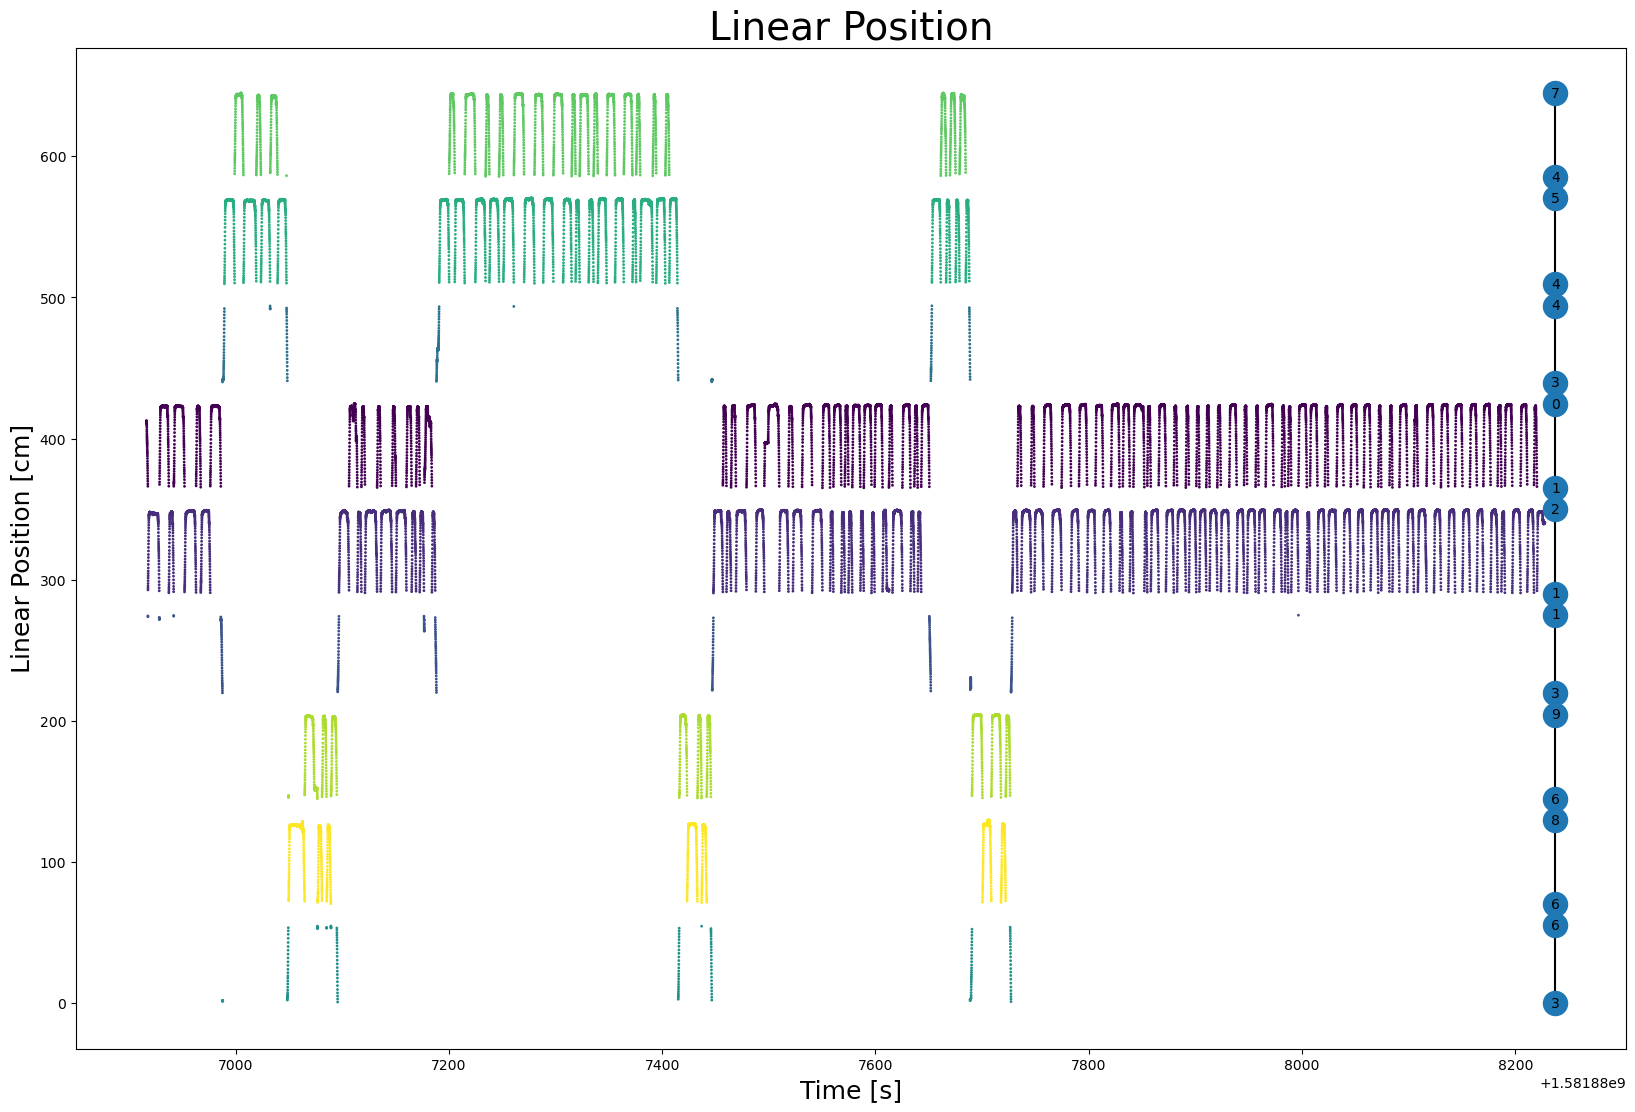

In [19]:
fig, ax = plt.subplots(figsize=(20, 13))
ax.scatter(
    linear_position_df.index,
    linear_position_df.linear_position,
    c=linear_position_df.track_segment_id,
    s=1,
)
graph.plot_track_graph_as_1D(
    ax=ax, axis="y", other_axis_start=linear_position_df.index[-1] + 10
)

ax.set_xlabel("Time [s]", fontsize=18)
ax.set_ylabel("Linear Position [cm]", fontsize=18)
ax.set_title("Linear Position", fontsize=28)

We can also plot the 2D position projected to the track graph


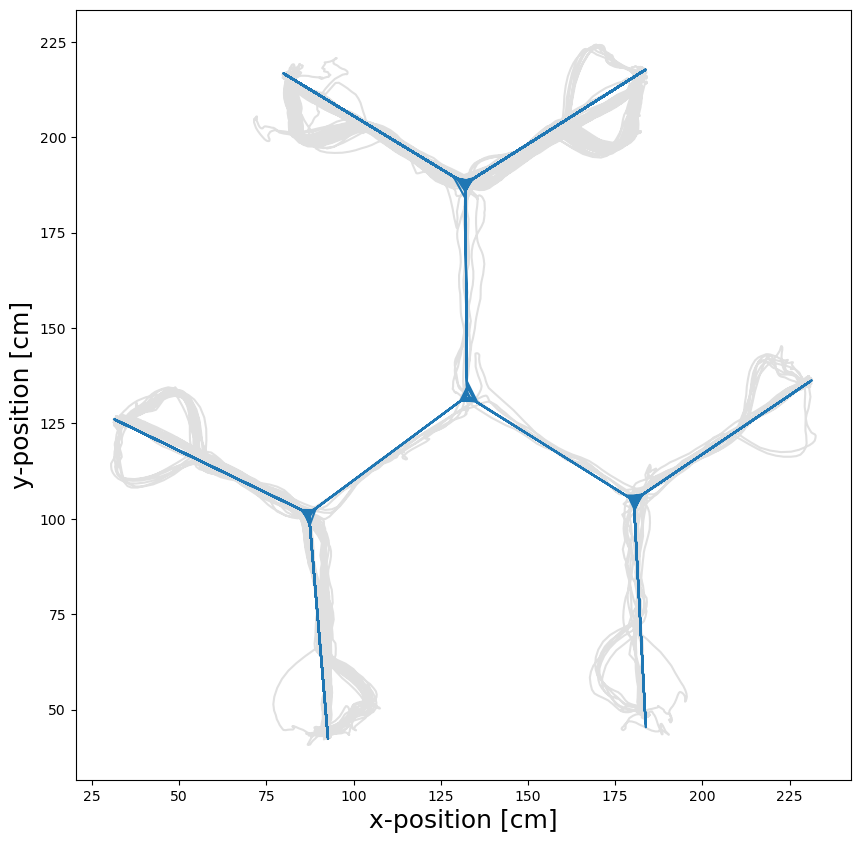

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(
    position_info.position_x,
    position_info.position_y,
    color="lightgrey",
    alpha=0.7,
    zorder=0,
)
ax.set_xlabel("x-position [cm]", fontsize=18)
ax.set_ylabel("y-position [cm]", fontsize=18)
ax.plot(
    linear_position_df.projected_x_position,
    linear_position_df.projected_y_position,
)